In [1]:
%matplotlib inline
workdir='../feedSim_hera_spec/'
c=3e8

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import gridspec
import cosmology
import numpy.fft as fft
import getPower
import interferometer
littleh=0.68

0.048252
[ 0.01051303  0.01766171  0.02492874 ...,  0.9296228   1.394404    1.945845  ]
(1316,)
(1316,)
(1316,)
[  4.5    4.5    4.5  ...,  34.38  34.38  34.38]
min klist
-1.97827209628



/Users/aaronew/default/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
uvw=np.load(workdir+'uvw_0.npy')
freqs=np.load(workdir+'freqs.npy')

select=freqs<158e6
freqs=freqs[select]
print freqs
#delays=np.load(workdir+'delays.npy')[select,:]
delays=fft.fftshift(fft.fftfreq(len(freqs),freqs[1]-freqs[0]))
model_ion=np.load(workdir+'cont_0_model.npy')[select,:]
model=np.load(workdir+'true_0_model.npy')[select,:]
beamP=np.load(workdir+'beamPs.npy')[select]
chanN=np.load(workdir+'bandnums.npy')
chanN=[len(beamP)]
#srcs=np.load(workdir+'srcs_0_2014_10_24.npy')
print uvw.shape
print model.shape
print model[0,1]
nf=len(freqs)
df=freqs[1]-freqs[0]
fc=freqs[nf/2]
z=cosmology.f2z(fc)
model_ion_list=[]
model_list=[]
model_resid_list=[]
freq_list=[]
nf_list=[]
fc_list=[]
band_list=[]
beam_list0=[]
beam_list1=[]
z_list=[]
delay_list=[]
base=0
print model_ion.shape
for mm in range(len(chanN)):
    nf_list.append(chanN[mm])
    freq_list.append(freqs[base:(base+nf_list[mm])])
    fc_list.append(freq_list[mm][nf_list[mm]/2])
    model_ion_list.append(model_ion[base:(base+chanN[mm]),:])
    model_list.append(model[base:base+chanN[mm],:])
    model_resid_list.append(model_ion_list[mm]-model_list[mm])
    band_list.append(freq_list[mm][-1]-freq_list[mm][0])
    beam_list0.append(beamP[base:(base+chanN[mm]),0])
    beam_list1.append(beamP[base:(base+chanN[mm]),1])
    z_list.append(cosmology.f2z(fc_list[mm]))
    delay_list.append(1./(df*nf_list[mm])*np.arange(-nf_list[mm]/2,nf_list[mm]/2))
    base+=nf_list[mm]
    



[  1.50000000e+08   1.50100000e+08   1.50200000e+08   1.50300000e+08
   1.50400000e+08   1.50500000e+08   1.50600000e+08   1.50700000e+08
   1.50800000e+08   1.50900000e+08   1.51000000e+08   1.51100000e+08
   1.51200000e+08   1.51300000e+08   1.51400000e+08   1.51500000e+08
   1.51600000e+08   1.51700000e+08   1.51800000e+08   1.51900000e+08
   1.52000000e+08   1.52100000e+08   1.52200000e+08   1.52300000e+08
   1.52400000e+08   1.52500000e+08   1.52600000e+08   1.52700000e+08
   1.52800000e+08   1.52900000e+08   1.53000000e+08   1.53100000e+08
   1.53200000e+08   1.53300000e+08   1.53400000e+08   1.53500000e+08
   1.53600000e+08   1.53700000e+08   1.53800000e+08   1.53900000e+08
   1.54000000e+08   1.54100000e+08   1.54200000e+08   1.54300000e+08
   1.54400000e+08   1.54500000e+08   1.54600000e+08   1.54700000e+08
   1.54800000e+08   1.54900000e+08   1.55000000e+08   1.55100000e+08
   1.55200000e+08   1.55300000e+08   1.55400000e+08   1.55500000e+08
   1.55600000e+08   1.55700000e+08

In [4]:
print fc_list

[153999999.99999976]


In [5]:
#load HERA Array and get noise for a 32 minute integration
antpos=np.loadtxt('line40_hybrid_spaced.txt')
hera=interferometer.getMRO(antpos,freqs)
hera.phasezenith()
hera.pointzenith()
noise_list=[]
for mm in range(len(fc_list)):
    noise=hera.delayNoise(250.,100*32.*60.,fc_list[mm])
    noise,_=np.meshgrid(noise,range(nf_list[mm]))
    noise_list.append(noise)

interferometer.py:451: RuntimeWarning: divide by zero encountered in divide
  return cosmology.X(fc)**2.*cosmology.Y(fc)*tsys150**2.*(fc/150e6)**(-2.5*2.)*self.beam.beamP(fc)**2./self.beam.beamPP(fc)/(2*tint*redundancy)


In [6]:

def plotps2d_list(xlist,ylist,datalist,title,xlabel,ylabel,vmin=2,vmax=19):
    if(len(datalist)>1):
        fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
    else:
        fig,axarr=plt.subplots(2,1,sharex=True,sharey=True)

    for mm in range(2):
        for nn in range(len(datalist)):
            im=axarr[mm][nn].imshow(np.log10(datalist[mm]),interpolation='nearest',extent=[xlist[mm].min(),xlist[mm].max(),ylist[mm].min(),ylist[mm].max()],vmin=vmin,vmax=vmax)
            axarr[mm][nn].set_title(title)
            axarr[mm][nn].set_xlabel(xlabel)
            axarr[mm][nn].set_ylabel(ylabel)
            axarr[mm][nn].set_aspect('auto','datalim')
    cax=fig.add_axes([.95,.1,.05,.8])
    fig.colorbar(im,cax=cax)
    fig.set_size_inches((len(datalist)/2*6,2*6))
def plotps2d_list_ascale(xlist,ylist,datalist,title,xlabel,ylabel):
    fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
    for mm in range(2):
        for nn in range(len(datalist)/2):
            im=axarr[mm][nn].imshow(np.log10(datalist[mm]),interpolation='nearest',extent=[xlist[mm].min(),xlist[mm].max(),ylist[mm].min(),ylist[mm].max()])
            axarr[mm][nn].set_title(title)
            axarr[mm][nn].set_xlabel(xlabel)
            axarr[mm][nn].set_ylabel(ylabel)
            axarr[mm][nn].set_aspect('auto','datalim')
    cax=fig.add_axes([.95,.1,.05,.8])
    fig.colorbar(im,cax=cax)
    fig.set_size_inches((len(datalist)/2*6,2*6))

In [7]:
def plotlist(datalist,bnum=10):
    fig,axarr=plt.subplots(1,len(datalist),sharex=True,sharey=True)
    for mm in range(len(datalist)):
        axarr[mm].plot((datalist[mm][:,bnum]))
        axarr[mm].set_aspect('auto','datalim')
    fig.set_size_inches((6*len(datalist),6))
def plotlist2(datalist1,datalist2,bnum=10):
    fig,axarr=plt.subplots(1,len(datalist1),sharex=True,sharey=True)
    for mm in range(len(datalist1)):
        axarr[mm].plot((datalist1[mm][:,bnum]))
        axarr[mm].plot((datalist2[mm][:,bnum]))
        axarr[mm].set_aspect('auto','datalim')
    fig.set_size_inches((6*len(datalist1),6))

Create binned uvw data with from visibility matrix output by simulation. vis is an nfreq x nvis x 3 complex numpy array. uvw is an nfreq x nvis  numpy array

/Users/aaronew/default/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


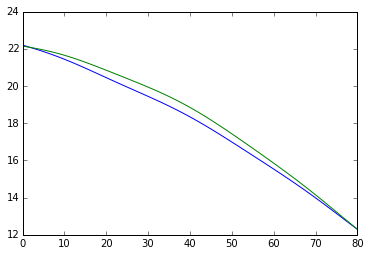

In [8]:
plt.plot(model[:,10])
plt.plot(model_ion[:,10])

(171, 3)


<matplotlib.colorbar.Colorbar instance at 0x10d0355f0>

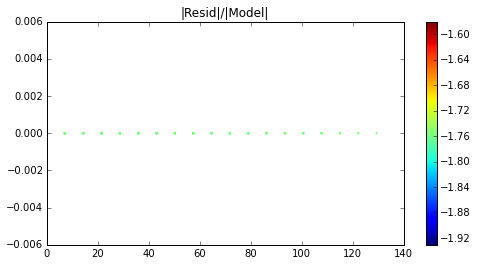

In [9]:
print uvw.shape
plt.scatter(uvw[:,0]*freqs[nf/2]/c,uvw[:,1]*freqs[nf/2]/c,c=np.log10(np.abs((model-model_ion)/model).mean(axis=0)),s=5,edgecolor='none')
plt.gcf().set_size_inches(8,4)
plt.title('|Resid|/|Model|')
plt.colorbar()

In [10]:
def delayTransform(vis,df):
    window=signal.blackmanharris(vis.shape[0])
    window=window/np.sqrt(np.mean(window**2.))
    windowx,windowy=np.meshgrid(range(vis.shape[1]),window)
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(vis*windowy,axes=0),axis=0),axes=0)*df
def delayTransformList(vislist,df):
    output=[]
    for mm in range(len(vislist)):
        output.append(delayTransform(vislist[mm],df))
    return output
def delay2PS(vis,beamP,band,f0):
    #convert to temperature power spectrum
    output=np.zeros_like(vis)
    for mm in range(vis.shape[1]):
        output[:,mm]=vis[:,mm]/np.sqrt(beamP*band)
    output=littleh**3.*(cosmology.X(f0)**2.*cosmology.Y(f0)*np.abs(cosmology.i2t(f0,output))**2.)*1e6
    return output
def delay2PSList(vislist,beamlist,bandlist,flist):
    output=[]
    for mm in range(len(vislist)):
        output.append(delay2PS(vislist[mm],beamlist[mm],bandlist[mm],flist[mm]))
    return output

In [11]:
dtrans_list=delayTransformList(model_list,df)
dtrans_ion_list=delayTransformList(model_ion_list,df)
dtrans_resid_list=delayTransformList(model_resid_list,df)
ps_list=delay2PSList(dtrans_list,beam_list1,band_list,fc_list)
ps_ion_list=delay2PSList(dtrans_ion_list,beam_list1,band_list,fc_list)
ps_resid_list=delay2PSList(dtrans_resid_list,beam_list1,band_list,fc_list)

7.18666666667


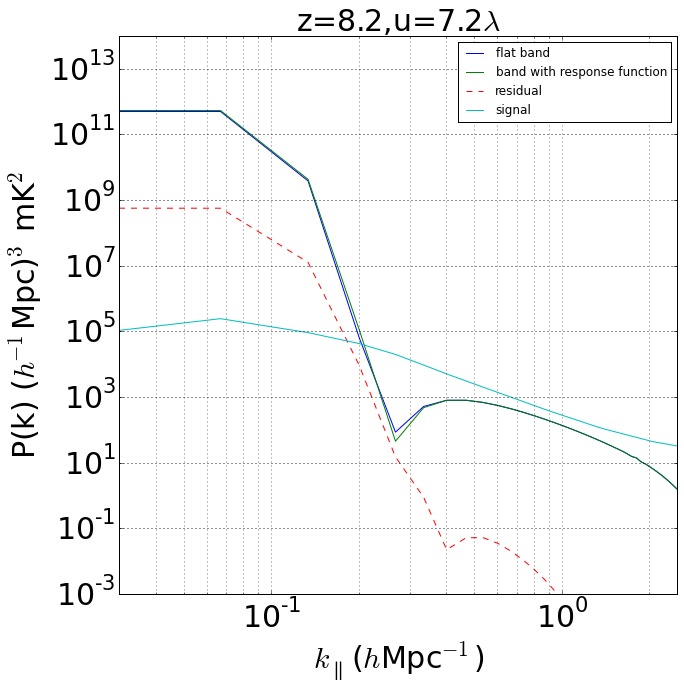

In [17]:
index=5
z0=cosmology.f2z(fc_list[0])
tuvw=uvw[index,:]
uvw_l=np.sqrt(np.sum(tuvw**2.))/c*freqs[nf/2]
print uvw_l
delayList=np.arange(-nf/2,nf/2)/(nf*df)
#print cosmology.eta2kpara(np.abs(delayList),z0)
#print ps_resid_list[0].shape
kList=cosmology.eta2kpara((delayList),z0)/.68
plt.plot(kList,ps_list[0][:,index],label='flat band')
plt.plot(kList,ps_ion_list[0][:,index],label='band with response function')
plt.plot(kList,ps_resid_list[0][:,index],label='residual',ls='--')


hz=cosmology.eta2kpara(uvw_l/freqs[nf/2],z0)/littleh
#plt.axvline(-hz+.1,color='k',ls='--')
#plt.axvline(hz+.1,color='k',ls='--')
#print getPower.ps21(cosmology.eta2kpara(np.abs(delayList),z0),z0*np.ones(len(delayList)))
plt.plot(kList,littleh**3.*getPower.ps21(cosmology.eta2kpara(np.abs(delayList),z0),z0*np.ones(len(delayList))),label='signal')
plt.yscale('log')
plt.xlabel('$k_\parallel$ ($h$Mpc$^{-1}$)',fontsize=30)
plt.ylabel('P(k) ($h^{-1}$Mpc)$^{3}$ mK$^2$',fontsize=30)
plt.legend(loc='best')
plt.gcf().set_size_inches(10,10)
plt.title('z=%.1f,u=%.1f$\\lambda$'%(cosmology.f2z(fc),uvw_l),fontsize=30)
plt.gca().tick_params('x',labelsize=30)
plt.gca().tick_params('y',labelsize=30)
plt.xlim(3e-2,2.5)
plt.xscale('log')
plt.grid(b=True,which='major')
plt.grid(b=True,which='minor')
plt.ylim(1e-3,1e14)
plt.savefig('../../spec_memo/figures/delay_response_compare_spec.pdf',bbox_inches='tight')

In [13]:
def binU(uvw,delays,data,nbins):
        u=np.sqrt(np.sum(uvw[:,:]**2.,axis=1))
        minu=u.min()
        maxu=u.max()
        du=(maxu-minu)/(nbins)
        ubins=np.zeros((data.shape[0]/2,nbins))
        etaaxis=np.zeros(data.shape[0]/2)
        counts=np.zeros(nbins)
        for mm in range(data.shape[0]/2):
            etaaxis[mm]=(np.abs(delays[data.shape[0]/2+mm])+np.abs(delays[data.shape[0]/2-mm]))/2
        for uvind in range(len(u)):
            ubin=int(np.round((u[uvind]-minu)/du))
            if(ubin>=0 and ubin<nbins):
                for mm in range(data.shape[0]/2):
                    ubins[mm,ubin]+=(data[mm+data.shape[0]/2,uvind]+data[data.shape[0]/2-mm,uvind])/2
                counts[ubin]+=1
        for m in range(nbins):
            ubins[:,m]=ubins[:,m]/counts[m]
        ubins[np.isnan(ubins)]=0.
        return np.linspace(minu,maxu,nbins),etaaxis,ubins
def binUList(uvw_list,delays_list,data_list,nbins):
    output=[]
    for mm in range(len(uvw_list)):
        output.append(binU(uvw_list[mm],delays_list[mm],data_list[mm],nbins))
    return output
def binU1D(uvw,delays,signal,weights,fc,flags,mink=1e-2,maxk=1.2,logscale=True,nbins=20):
    z=cosmology.f2z(fc)
    u=np.sqrt(np.sum(uvw[:,:]**2.,axis=1))
    kperp=cosmology.u2kperp(u,z)/littleh
    kpara=cosmology.eta2kpara(delays,z)/littleh
    kperpg,kparag=np.meshgrid(kperp,kpara)#kperp/kparallel of all visibilities
    kg=np.sqrt(kperpg**2.+kparag**2.)
    if(logscale):
        kg=np.log10(kg)
        mink=np.log10(mink)
        maxk=np.log10(maxk)
    kg=kg[flags].flatten()
    signal=signal[flags].flatten()
    weights=weights[flags].flatten()
    ps=np.zeros(nbins)
    cts=np.zeros(nbins)
    ks=np.zeros(nbins)
    dk=(maxk-mink)/nbins
    for mm in range(len(kg)):
        kbin=int((kg[mm]-mink)/dk)
        if(logscale):
            k=kg[mm]**2.
        else:
            k=kg[mm]
        if(kbin>=0 and kbin<nbins):
            ps[kbin]+=signal[mm]*weights[mm]
            cts[kbin]+=weights[mm]
            ks[kbin]+=k
    return cts,ks/cts,ps/cts

#bin the noise assuming inverse square weighting
def binNoise1D(uvw,delays,noise,fc,flags,mink=1e-2,maxk=1.,logscale=True,nbins=20):
    z=cosmology.f2z(fc)
    u=np.sqrt(np.sum(uvw[:,:]**2.,axis=1))
    kperp=cosmology.u2kperp(u,z)/littleh
    kpara=cosmology.eta2kpara(delays,z)/littleh
    kperpg,kparag=np.meshgrid(kperp,kpara)#kperp/kparallel of all visibilities
    kg=np.sqrt(kperpg**2.+kparag**2.)
    if(logscale):
        kg=np.log10(kg)
        mink=np.log10(mink)
        maxk=np.log10(maxk)
    #now apply mask
    kg=kg[flags].flatten()
    noise=noise[flags].flatten()
    ps=np.zeros(nbins)
    cts=np.zeros(nbins)
    ks=np.zeros(nbins)
    dk=(maxk-mink)/nbins
    print len(noise)
    for mm in range(len(noise)):
        kbin=int((kg[mm]-mink)/dk)
        if(logscale):
            k=10.**kg[mm]
        else:
            k=kg[mm]
        if(kbin>=0 and kbin<nbins):
            ps[kbin]+=1/noise[mm]**2.
            cts[kbin]+=1
            ks[kbin]+=k
    ps=np.sqrt(1./ps)
    ps[np.logical_or(np.isnan(ps),np.isinf(ps))]=9e99
    return cts,ks/cts,ps
    #not interate through every cell 

In [14]:
def wedgeflag(uvw,eta,fc,offset,bfwhm):
    offset=cosmology.kpara2eta(offset/littleh,cosmology.f2z(fc))
    u=np.sqrt(np.sum(uvw[:,:-1]**2.,axis=1))
    ug,etag=np.meshgrid(u,eta)
    #plt.imshow(etag)
    #plt.colorbar()
    #plt.show()
    #plt.imshow(ug)
    #plt.colorbar()
    #plt.show()
    
    return np.abs(ug/c)<=(np.abs(etag)-offset)/np.sin(np.radians(bfwhm/2.))
flags=wedgeflag(uvw*fc_list[mm]/c,delay_list[mm],fc_list[mm],0.2,180.)


In [15]:
cuvw_list=[]
for mm in range(len(chanN)):
    cuvw_list.append(uvw*freq_list[mm][nf_list[mm]/2]/c)
ubins_list=binUList(cuvw_list,delay_list,ps_list,15)
ubins_ion_list=binUList(cuvw_list,delay_list,ps_ion_list,15)
ubins_resid_list=binUList(cuvw_list,delay_list,ps_resid_list,15)
kperp_list=[]
kpara_list=[]
psbin_list=[]
psbin_ion_list=[]
psbin_resid_list=[]
for mm in range(len(chanN)):
    psbin_list.append(ubins_list[mm][2])
    psbin_ion_list.append(ubins_ion_list[mm][2])
    psbin_resid_list.append(ubins_resid_list[mm][2])
    kpara_list.append(cosmology.eta2kpara(ubins_list[mm][1],z_list[mm])/littleh)
    kperp_list.append(cosmology.u2kperp(ubins_list[mm][0],z_list[mm])/littleh)

"\nflaggrid=np.ones(psbin_list[0].shape)\nflaggrid[flags]=1.\nflaggrid[np.invert(flags)]=0.\nplt.pcolor(kperpg,kparag,np.log10(psbin_list[0][1:,1:]))\nplt.yscale('log')\nplt.xscale('log')\nplt.gca().set_aspect('auto')\n"

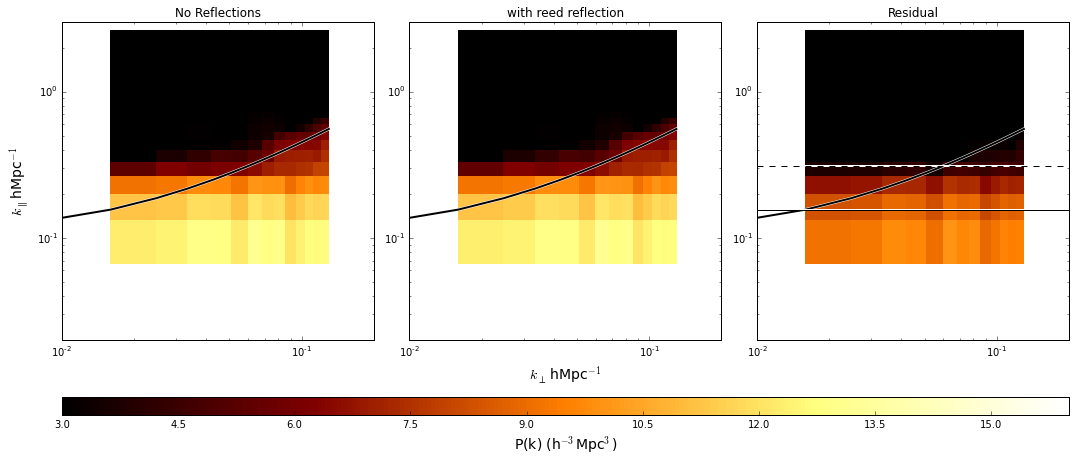

In [16]:
my_cm='afmhot'
kperpg,kparag=np.meshgrid(kperp_list[0][1:],kpara_list[0][1:])
gs=gridspec.GridSpec(7,3)
axarr=[plt.subplot(gs[:-2,mm]) for mm in range(3)]
axarr.append(plt.subplot(gs[-2:-1,:]))
axarr[0].set_title('No Reflections')
axarr[0].pcolor(kperpg,kparag,np.log10(psbin_list[0][1:,1:]),vmin=3.,vmax=16,cmap=my_cm)
axarr[0].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=3,color='w')
axarr[0].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=2,color='k',ls='-')
axarr[0].set_yscale('log')
axarr[0].set_xscale('log')
axarr[0].set_aspect('auto')
#axarr[0].set_xlabel('$k_\\perp$ h/Mpc')
#axarr[0].set_ylabel('$k_\\parallel$ h/Mpc')
axarr[0].set_xlim(1e-2,2e-1)
axarr[0].set_ylim(2e-2,3e0)

axarr[1].set_title('with reed reflection')
axarr[1].pcolor(kperpg,kparag,np.log10(psbin_ion_list[0][1:,1:]),vmin=3.,vmax=16,cmap=my_cm)
axarr[1].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=3,color='w')
axarr[1].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=2,color='k',ls='-')
axarr[1].set_yscale('log')
axarr[1].set_xscale('log')
axarr[1].set_xlim(1e-2,2e-1)
axarr[1].set_xlabel('$k_\\perp$ hMpc$^{-1}$',fontsize=14)
#axarr[1].set_ylabel('$k_\\parallel$ h/Mpc')
axarr[1].set_aspect('auto')
axarr[1].set_ylim(2e-2,3e0)

axarr[2].set_title('Residual')
im=axarr[2].pcolor(kperpg,kparag,np.log10(psbin_resid_list[0][1:,1:]),vmin=3.,vmax=16.,cmap=my_cm)
axarr[2].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=3,color='w')
axarr[2].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=2,color='k',ls='-')
axarr[2].set_yscale('log')
axarr[2].set_xscale('log')
axarr[2].set_xlim(1e-2,2e-1)
axarr[2].set_aspect('auto')
axarr[2].set_ylim(2e-2,3e0)
#axarr[2].set_xlabel('$k_\\perp$ h/Mpc')
axarr[0].set_ylabel('$k_\\parallel$ hMpc$^{-1}$',fontsize=14)
axarr[2].axhline(cosmology.eta2kpara(2.*35./(3e8*.81),cosmology.f2z(fc))/littleh,color='w',lw=2)
axarr[2].axhline(cosmology.eta2kpara(4.*35./(3e8*.81),cosmology.f2z(fc))/littleh,color='w',lw=2,ls='-')


axarr[2].axhline(cosmology.eta2kpara(2.*35./(3e8*.81),cosmology.f2z(fc))/littleh,color='k',lw=1)
axarr[2].axhline(cosmology.eta2kpara(4.*35./(3e8*.81),cosmology.f2z(fc))/littleh,color='k',lw=1,ls='--')



fig=plt.gcf()
#cbar_ax=fig.add_axes([0.1,0.05,.8,.05])
cbar=fig.colorbar(im,cax=axarr[-1],orientation='horizontal')
cbar.set_label('P(k) (h$^{-3}$Mpc$^{3}$)',fontsize=14)

fig.set_size_inches([15,7])
plt.tight_layout()
plt.savefig('../../spec_memo/figures/hera_reflections_EoX_feed.png',bbox_inches='tight')
'''
flaggrid=np.ones(psbin_list[0].shape)
flaggrid[flags]=1.
flaggrid[np.invert(flags)]=0.
plt.pcolor(kperpg,kparag,np.log10(psbin_list[0][1:,1:]))
plt.yscale('log')
plt.xscale('log')
plt.gca().set_aspect('auto')
'''

In [19]:
def psgrid(kperpaxis,kparaaxis,z):
    kperpg,kparag=np.meshgrid(kperpaxis,kparaaxis)
    zs=z*np.ones(kperpg.shape)
    return getPower.ps21_c(kperpg,kparag,zs)
def psgrid_list(kperplist,kparalist,zlist):
    output=[]
    for mm in range(len(kperplist)):
        output.append(psgrid(kperplist[mm],kparalist[mm],zlist[mm]))
    return output

In [40]:
noise1D=[]
noise1Dr=[]
resid1D=[]
signal1D=[]
klist1D=[]
ctlist1D=[]
foreground1D=[]
resid1Dr=[]
signal1Dr=[]
usq1D=[]
for mm in range(len(noise_list)):
    flags=wedgeflag(uvw,delay_list[mm],fc_list[mm],0.05,180.)
    #flags[:]=True
   # flags=np.empty((delay_list[mm].shape[0],uvw.shape[0]),dtype=bool)
    kperp=cosmology.u2kperp(np.sqrt(np.sum(uvw[:,:2]**2.,axis=1))*fc_list[mm]/c,z)
    kpara=cosmology.eta2kpara(delay_list[mm],z)
    ps_21=psgrid(kperp,kpara,z_list[mm])
    #flags[:]=True
    z=z_list[mm]
    nresult=binNoise1D(uvw*fc_list[mm]/c,delay_list[mm],noise_list[mm],fc_list[mm],flags,maxk=2.2)
    klist1D.append(nresult[1])
    ctlist1D.append(nresult[0])
    noise1D.append(nresult[2])
    uvsq,_=np.meshgrid(np.sum(uvw[:,:2]**2.,axis=1)*fc_list[mm]/c,delay_list[mm])
    usq1D.append(binU1D(uvw*fc_list[mm]/c,delay_list[mm],uvsq,np.ones(ps_resid_list[mm].shape),fc_list[mm],flags,maxk=2.2)[2])
    resid1D.append(binU1D(uvw*fc_list[mm]/c,delay_list[mm],ps_resid_list[mm],np.ones(ps_resid_list[mm].shape),fc_list[mm],flags,maxk=2.2)[2])
    signal1D.append(binU1D(uvw*fc_list[mm]/c,delay_list[mm],ps_21,np.ones(ps_resid_list[mm].shape),fc_list[mm],flags,maxk=2.2)[2])
    foreground1D.append(binU1D(uvw*fc_list[mm]/c,delay_list[mm],ps_list[mm],np.ones(ps_resid_list[mm].shape),fc_list[mm],flags,maxk=2.2)[2])

24593


[        nan         nan         nan         nan         nan         nan
         nan         nan         nan  0.13741339  0.17191119  0.22772246
  0.2941172   0.38109979  0.50158357  0.65445412  0.85962832  1.13355278
  1.47621736  1.93902006]


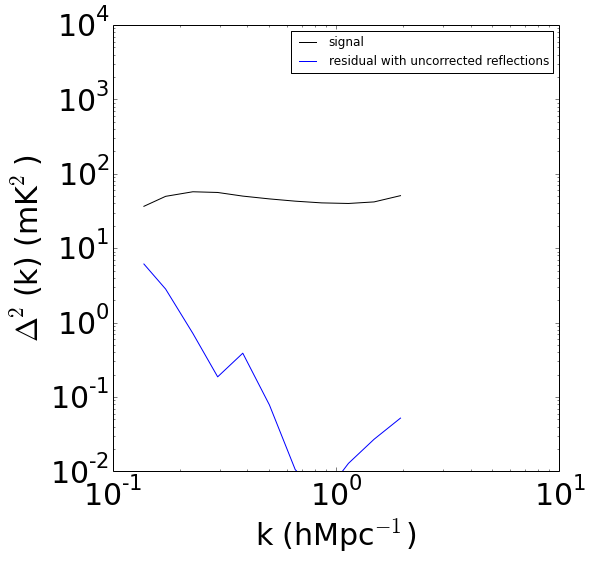

In [45]:
#fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
print klist1D[0]
mm=0
#klist1D[mm],usq1D[mm]*resid1D[mm][5]/usq1D[mm][5]*klist1D[mm]**3./(2.*np.pi**2.),
#plt.plot(klist1D[mm],noise1D[mm]*klist1D[mm]**3./(2.*np.pi**2.)*1e6,':r',klist1D[mm],signal1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-k',klist1D[mm],resid1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-b',klist1D[mm],foreground1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),':b')
plt.plot(klist1D[mm],signal1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-k',label='signal')
plt.plot(klist1D[mm],resid1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-b',label='residual with uncorrected reflections')
#plt.plot(klist1D[mm],foreground1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),':b',label='unsubtracted foregrounds with no reflection')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\\Delta^2$(k) (mK$^2$)',fontsize=30)
plt.xlabel('k (hMpc$^{-1}$)',fontsize=30)
plt.gca().tick_params('x',labelsize=30)
plt.gca().tick_params('y',labelsize=30)


plt.ylim([1e-2,1e4])
plt.legend(loc='best')
plt.gcf().set_size_inches(8,8)
plt.gca().set_aspect('auto')
plt.savefig('../../spec_memo/figures/hera_1dPower_EoR_feed_spec.pdf',bbox_inches='tight')



[        nan         nan         nan         nan  0.03510322         nan
         nan  0.06959074  0.10480242  0.13926047  0.17373204  0.22669849
  0.29593819  0.3819895   0.50097108  0.65445412  0.85962832  1.13355278
  1.47621736  1.93902006]


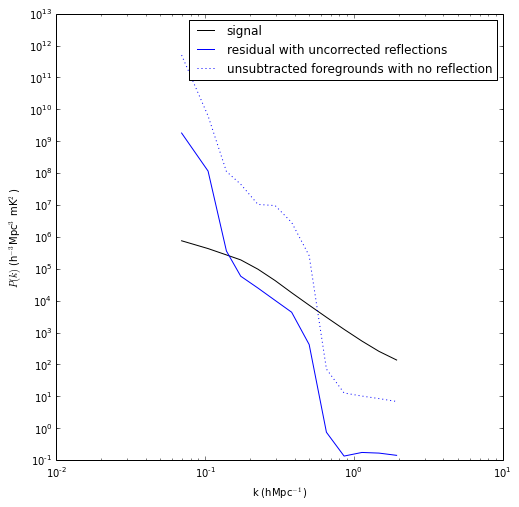

In [22]:
#fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
print klist1D[0]
mm=0
#klist1D[mm],usq1D[mm]*resid1D[mm][5]/usq1D[mm][5]*klist1D[mm]**3./(2.*np.pi**2.),
#plt.plot(klist1D[mm],noise1D[mm]*klist1D[mm]**3./(2.*np.pi**2.)*1e6,':r',klist1D[mm],signal1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-k',klist1D[mm],resid1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-b',klist1D[mm],foreground1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),':b')
plt.plot(klist1D[mm],signal1D[mm],'-k',label='signal')
plt.plot(klist1D[mm],resid1D[mm],'-b',label='residual with uncorrected reflections')
plt.plot(klist1D[mm],foreground1D[mm],':b',label='unsubtracted foregrounds with no reflection')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P(k)$ (h$^{-3}$Mpc$^{3}$ mK$^2$)')
plt.xlabel('k (hMpc$^{-1}$)')
#plt.ylim([1e-3,1e12])
plt.legend(loc='best')
plt.gcf().set_size_inches(8,8)
plt.gca().set_aspect('auto')
plt.savefig('../../spec_memo/figures/hera_Ps_EoR_feed.pdf',bbox_inches='tight')



In [23]:
np.all(flags)

False

In [24]:
#fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
mm=0
plt.plot(klist1D[mm],noise1Dr[mm]*klist1D[mm]**3./(2.*np.pi**2.)*1e6,'--r',klist1D[mm],noise1D[mm]*klist1D[mm]**3./(2.*np.pi**2.)*1e6,':r',klist1D[mm],signal1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-k',klist1D[mm],resid1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-b',klist1D[mm],resid1Dr[mm]*klist1D[mm]**3./(2.*np.pi**2.),'--b',klist1D[mm],foreground1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),':b')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\\Delta^2$(k) (mK$^2$)')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylim([1e-2,1e12])
plt.gca().set_aspect('auto')

ERROR: IndexError: list index out of range [IPython.core.interactiveshell]
# ERROR:astropy: IndexError: list index out of range


IndexError: list index out of range

In [ ]:
kperp_list

In [ ]:
plotps2d_list(kperp_list,kpara_list,psbin_resid_list,'P$_{fg}$(Mpc$^3$mK$^2$)','kperp','kpara',vmin=2.,vmax=15)

In [ ]:
theory=psgrid_list(kperp_list,kpara_list,z_list)
ratios=[]
for mm in range(len(theory)):
    ratios.append(theory[mm]/psbin_resid_list[mm])

In [ ]:
plotps2d_list(kperp_list,kpara_list,ratios,'P$_{21}$/P$_r$','kperp','kpara',vmin=-5,vmax=3)

In [ ]:
fc

In [15]:
print cosmology.eta2kpara(60e-9,8)

0.022380178217
